# ST239 Assignment 1 - u5558899


##### Imports and dataset setup:

In [ ]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.optimize import curve_fit

# Path setup
spam_phishing_path = Path("./spam_phishing.csv")
Q2_curve_path = Path("./Q2_curve.csv")
weekly_emails_path = Path("./weekly_emails.csv")
house_energy_path =  Path("./house_energy.csv")

#Dataframes setup
spam_df = pd.read_csv(spam_phishing_path)
curve_df = pd.read_csv(Q2_curve_path)
emails_df = pd.read_csv(weekly_emails_path)
house_df = pd.read_csv(house_energy_path)
mpg = sns.load_dataset('mpg').dropna()



,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


# Question 1: Simple 'Linear' Regression

### (a) Context on Transforming Variables


For an OLS linear regression, we assume the regressor and regressand(s) have a linear relationship that can be depicted using some model $Y = \beta_0 + \beta_1 X + \epsilon$  

However, data does not show linear relationships in all cases, sometimes it shows exponential growth/decay or some sort of polynomial form. Fitting a linear model to capture this relationship would just yield biased and/or inconsistent estimators with residual non-normality and/or heteroskedasticity.

To address this, we can apply a tansformatio to the regressor(s) or the dependent variable (or both) to linearize the relationship. 


For our MPG examples, we can see some exponential (yet moderate) decay in the continuous variable except for acceleration which shows a slight positive curvature (quasi linear-ish).  

Both Log ($ ln $) and inverse ($ 1/x $)transformations are valid, although we have to be careful with the inverse worsening outliers that are near $0$ (since $1/x$ would tend to infinity)


The new model would be:
$$Y = \beta_0 + \beta_1 f(X) + \epsilon$$
where $f(X)$ is the transformed variable. This is still a "linear" regression model because it is 'linear' with parameters $\beta_0$ and $\beta_1$.  \

<br>

  
#### ** EDA and transformations on MPG dataset below:**

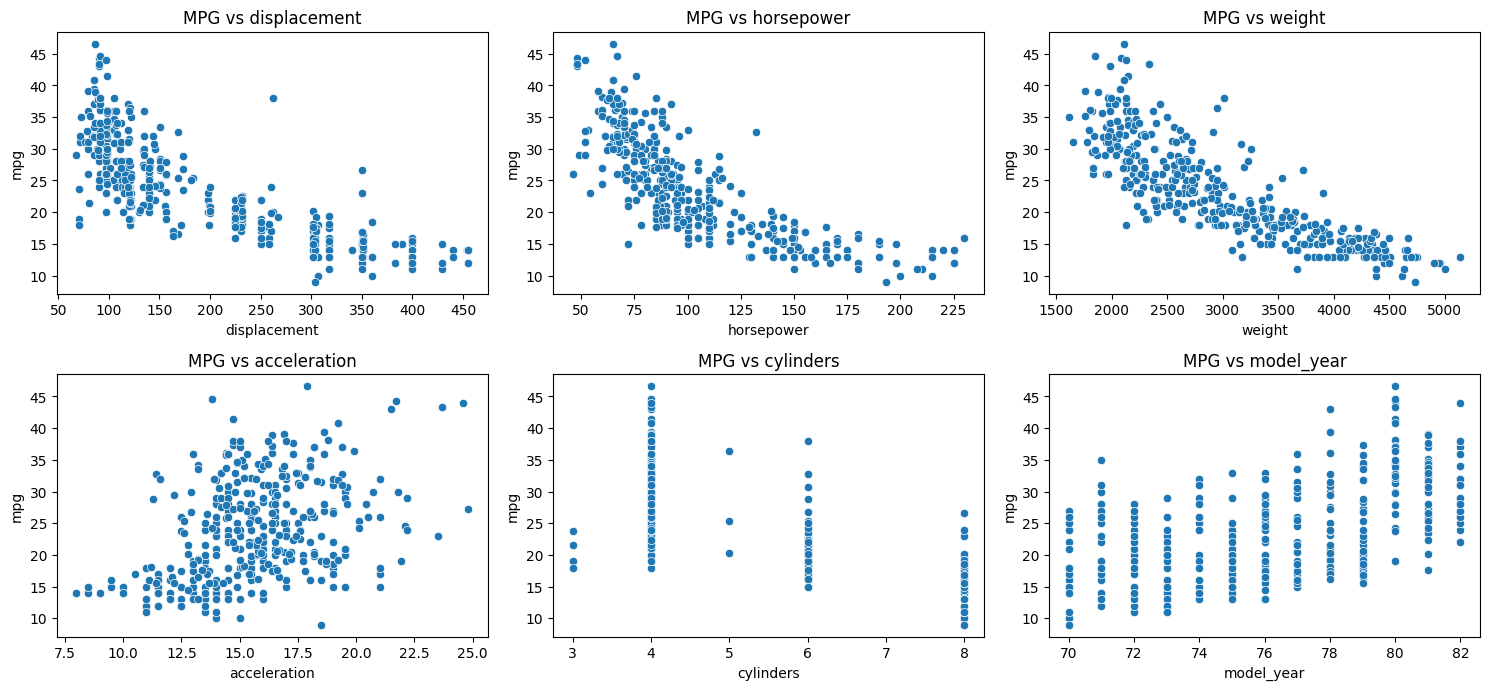

In [3]:
variables = ['displacement', 'horsepower', 'weight', 'acceleration', 'cylinders', 'model_year']

plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):                 #  just plots
    plt.subplot(3, 3, i)
    sns.scatterplot(data=mpg, x=var, y='mpg')
    plt.title(f'MPG vs {var}')
plt.tight_layout()
plt.show()

**Observations:**  \
as mentioned before, we see this decaying relationship in all continuous variables except acceleration (positive quasi linear-ish)

  
Mathematical Model:
$$ \text{mpg} = \beta_0 + \beta_1 \left( \frac{1}{\text{explanatory\_variable}} \right) + \epsilon $$

or 

$$ \text{mpg} = \beta_0 + \beta_1 \ln(\text{explanatory\_variable}) + \epsilon $$





### (b) Fitting transformed regressors



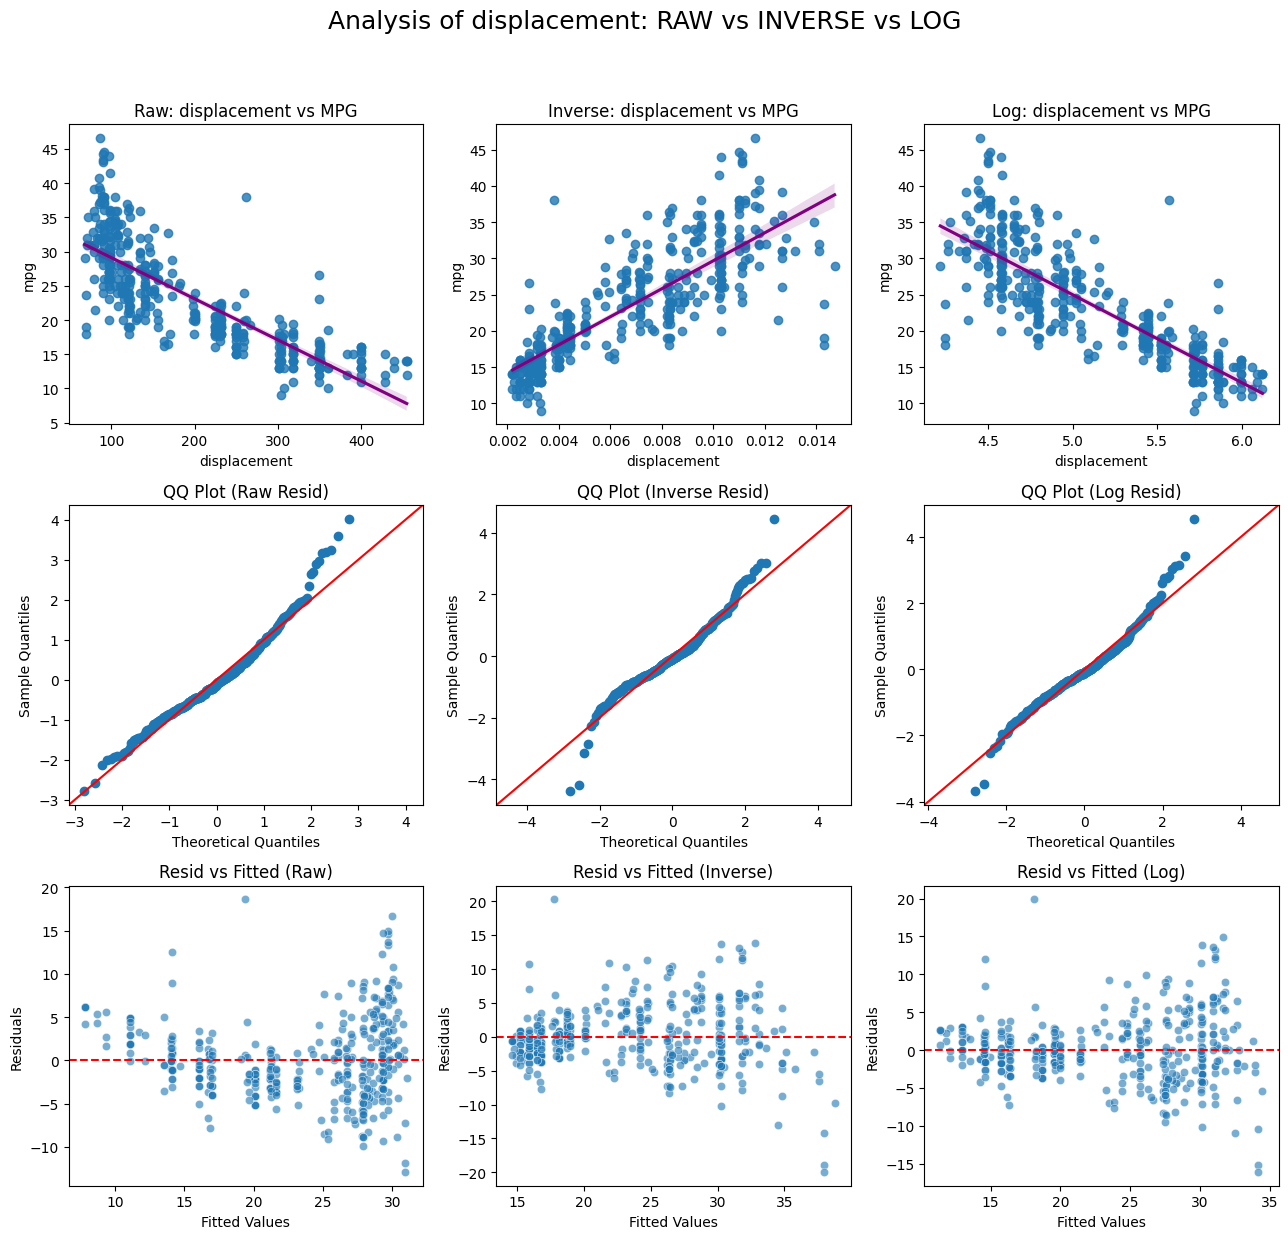

--- Statistics for displacement ---
Transfrmation | R^2  | p-value | MSE (model)
---------------------------------------------
Raw      | 0.648 | 1.6606e-90 | 15440
Inverse  | 0.661 | 1.3764e-93 | 15739
Log      | 0.686 | 3.1497e-100 | 16348
/n


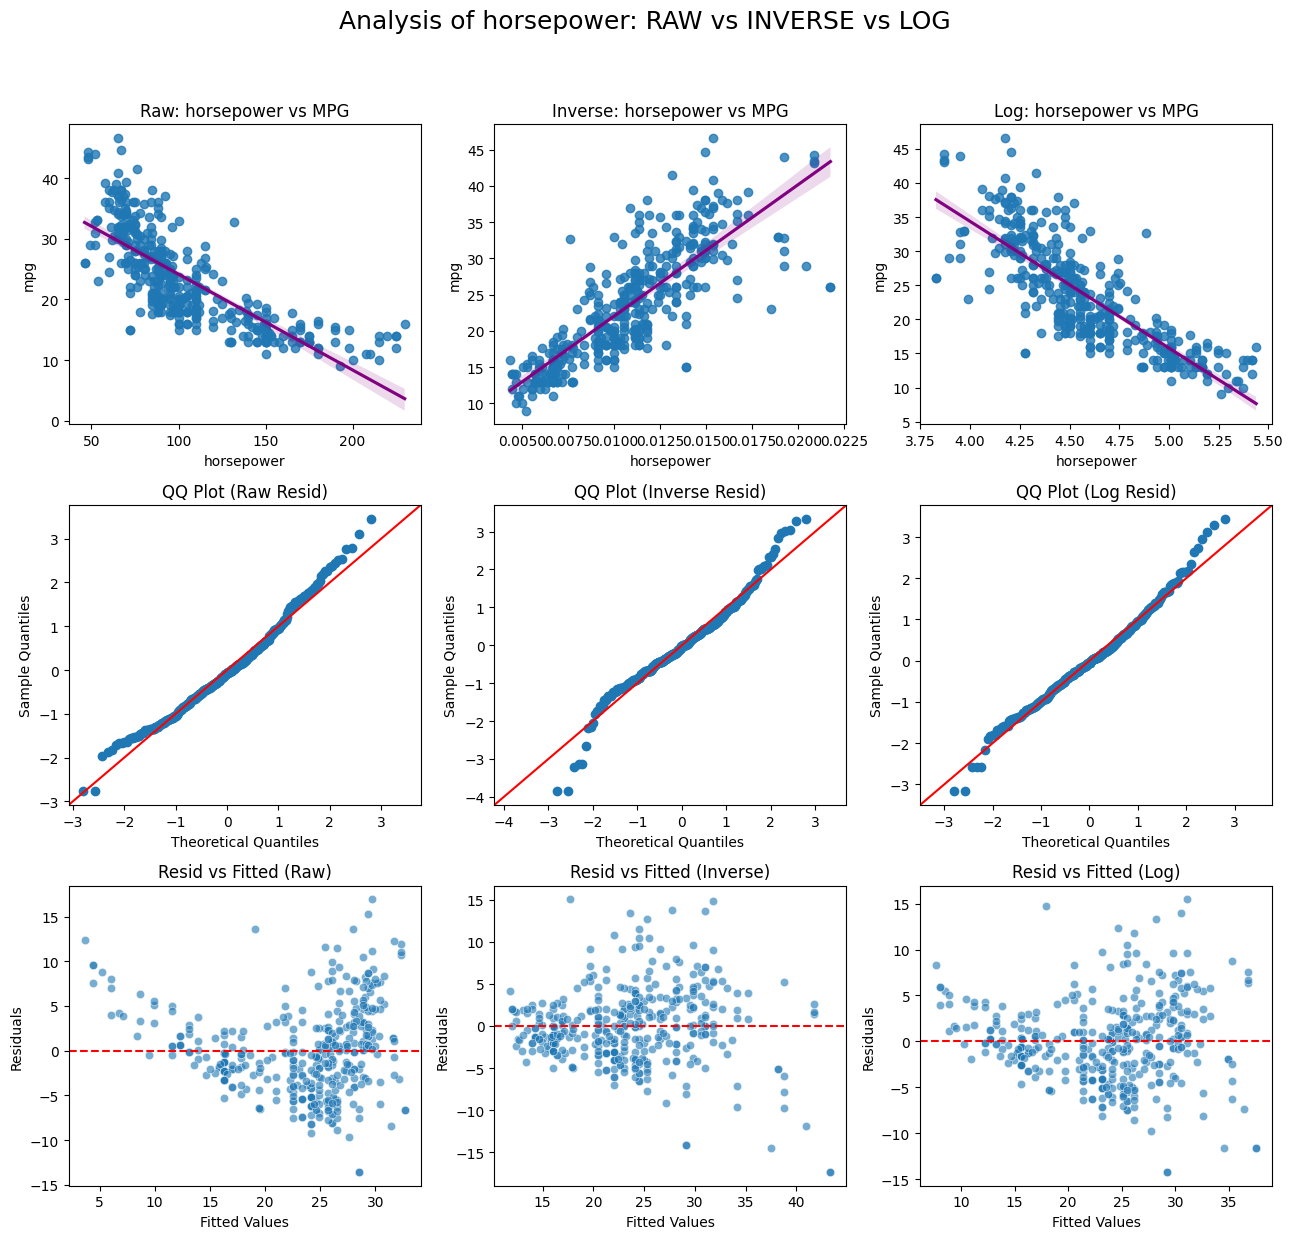

--- Statistics for horsepower ---
Transfrmation | R^2  | p-value | MSE (model)
---------------------------------------------
Raw      | 0.606 | 7.0320e-81 | 14433
Inverse  | 0.667 | 3.4875e-95 | 15890
Log      | 0.668 | 1.6966e-95 | 15919
/n


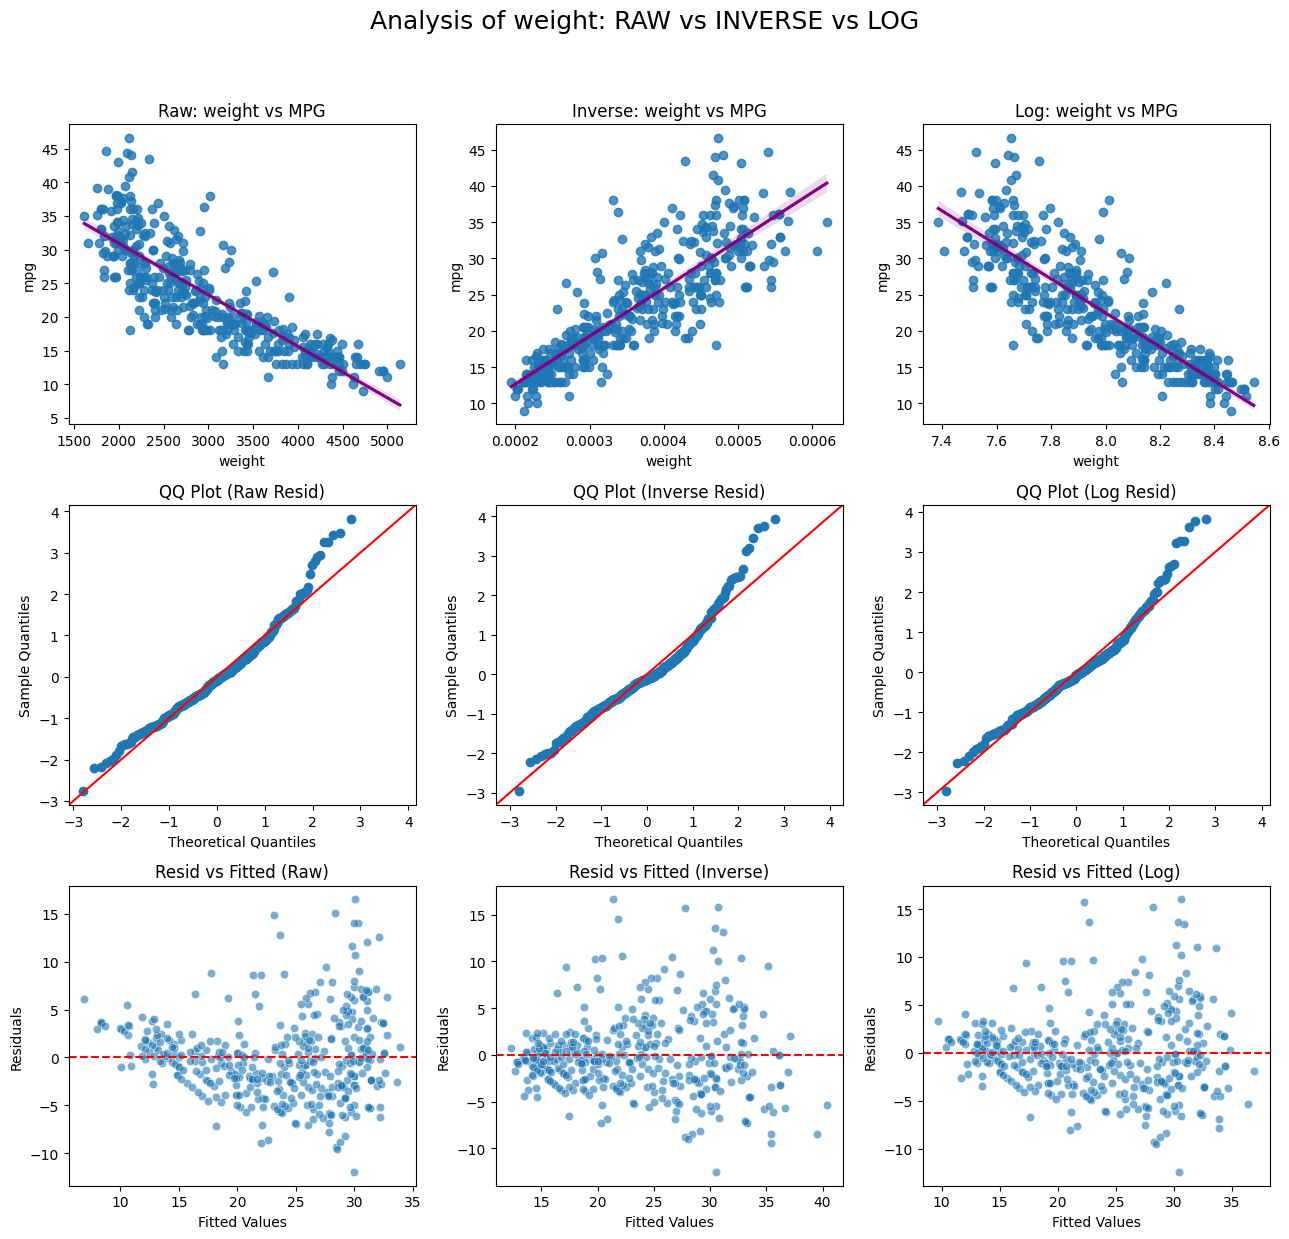

--- Statistics for weight ---
Transfrmation | R^2  | p-value | MSE (model)
---------------------------------------------
Raw      | 0.693 | 6.0153e-102 | 16498
Inverse  | 0.707 | 6.2204e-106 | 16834
Log      | 0.713 | 1.1629e-107 | 16975
/n


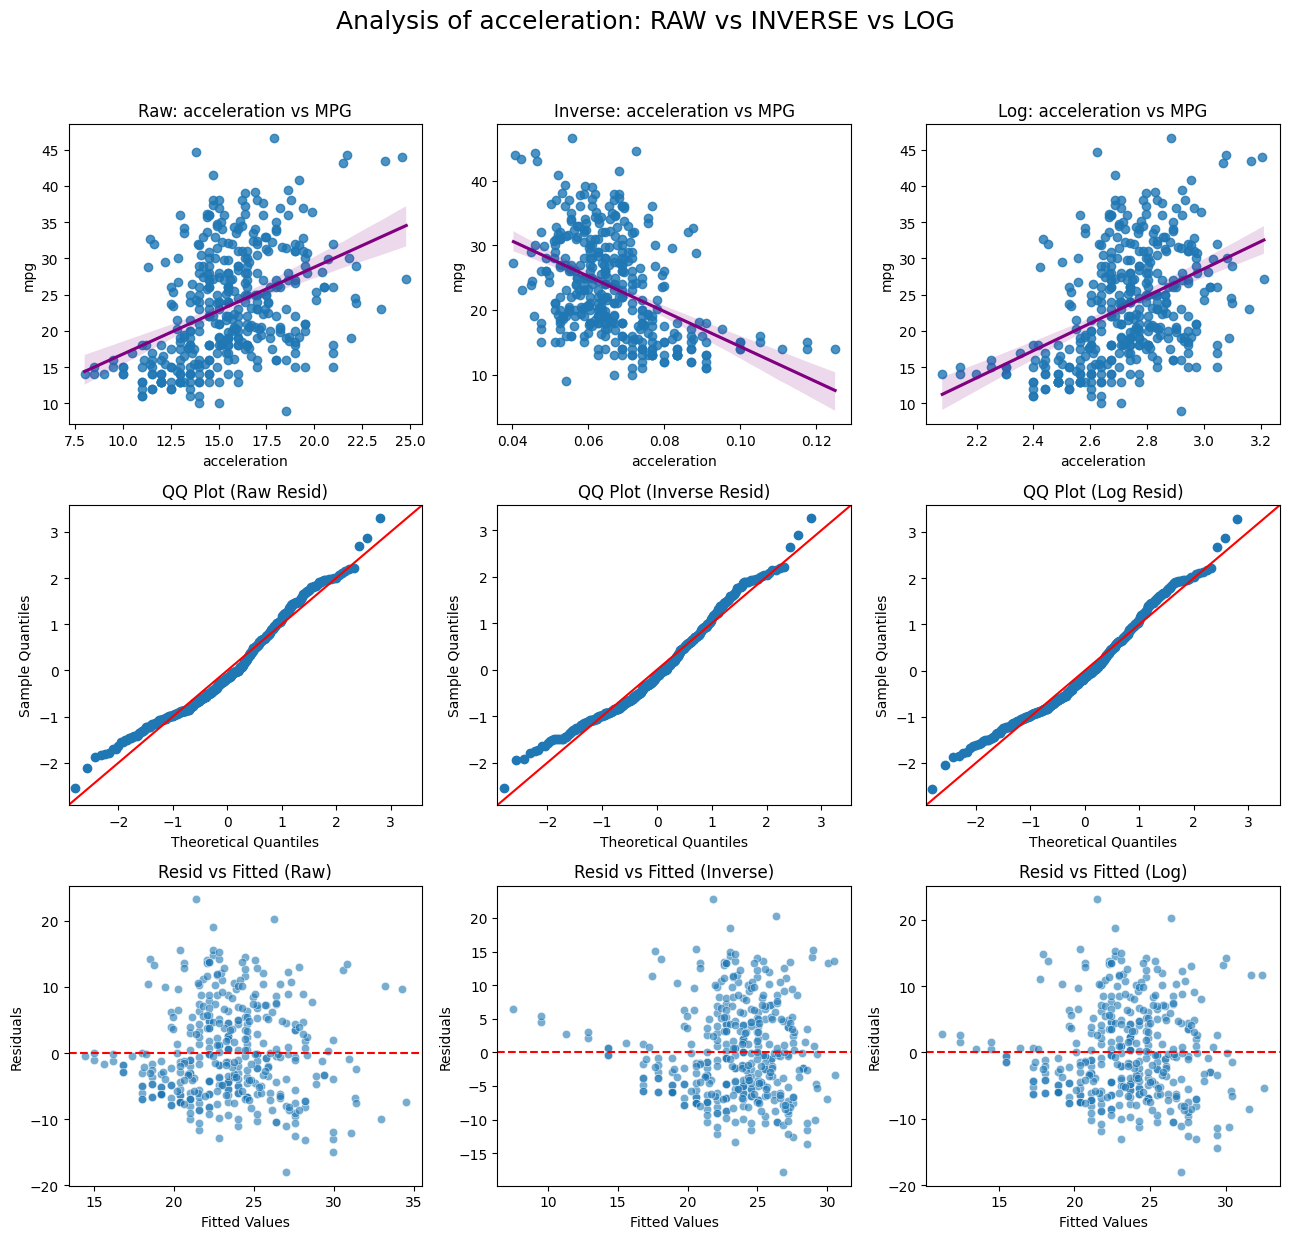

--- Statistics for acceleration ---
Transfrmation | R^2  | p-value | MSE (model)
---------------------------------------------
Raw      | 0.179 | 1.7786e-18 | 4269
Inverse  | 0.192 | 7.4916e-20 | 4580
Log      | 0.190 | 1.3054e-19 | 4526
/n


In [4]:
# Comparison of Raw vs Inverse vs Log Predictors

target = 'mpg'
predictors = ['displacement', 'horsepower', 'weight', 'acceleration']


for var in predictors:
 
    fig, axes = plt.subplots(3, 3, figsize=(13, 13))
    fig.suptitle(f'Analysis of {var}: RAW vs INVERSE vs LOG', fontsize=18)

    data = mpg[[var, target]].dropna()
    y = data[target]
    
    # Transformations
    x_raw = data[var]
    x_inv = 1 / data[var]
    x_log = np.log(data[var])
    
    # dict for iterations
    variations = {
        'Raw': x_raw,
        'Inverse': x_inv,
        'Log': x_log
    }
    
    stats_summary = []

    # Loop through columns 
    for col_idx, (name, x_data) in enumerate(variations.items()):

        # Fit Model
        X = sm.add_constant(x_data)
        model = sm.OLS(y, X).fit()
        stats_summary.append((name, model.rsquared, model.pvalues.iloc[1], model.mse_model))

        # Regression plots 
        sns.regplot(x=x_data, y=y, ax=axes[0, col_idx], line_kws={'color': 'purple'})
        axes[0, col_idx].set_title(f'{name}: {var} vs MPG')
        axes.titlesize : large

        # QQ plots
        sm.qqplot(model.resid, line='45', fit=True, ax=axes[1, col_idx])
        axes[1, col_idx].set_title(f'QQ Plot ({name} Resid)')

        # Scale location plots
        sns.scatterplot(x=model.fittedvalues, y=model.resid, ax=axes[2, col_idx], alpha=0.6)
        axes[2, col_idx].axhline(0, color='red', linestyle='--')
        axes[2, col_idx].set_xlabel('Fitted Values')
        axes[2, col_idx].set_ylabel('Residuals')
        axes[2, col_idx].set_title(f'Resid vs Fitted ({name})')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Print Statistics Comparison
    print(f"--- Statistics for {var} ---")
    print(f"{'Transfrmation':<10} | {'R^2':<4} | {'p-value'} | {'MSE (model)'}")
    print("-"*45)
    for name, r2, pval, mse in stats_summary:
        print(f"{name:<8} | {r2:.3f} | {pval:.4e} | {mse:.0f}")
    print("="*50)
    print('/n')


### c) Interpretation and best model:



**Displacement**: (Best $R^2: 0.69 $, MSE $: 16348 $)
- Inversing displcament causes compression of the larger raw values into near 0 inversed values, making them cluster below the regression line and causing the huge drop in the lower quantiles of the QQ plot. Log transformation has a milder but similar effect, and both improve (but not solve) the heteroscedasticity. Log overall winner.

**Horsepower**: (Best $R^2: 0.67 $, MSE $: 15919$)
-  This case is a bit tricky, similarly to displcament,  inversing horsepower distorts the tails of the QQ plot since larger horsepower values become 'crunched' towards the bottom left and become too small on the x-axis. The QQ Plot of residuals then shows a huge drop on it's lowest left (negative) quantiles. Something similar happens with log but not as intense. Both transformations 'improve' the heteroscedasticity shown in fitted vs residuals plot. The best transformation would be log (best at MSE-R2-QQ)

**Weight**:  (Best $R^2: 0.71$, MSE $: 16975 $)
-  For weight there isn't much effect for the QQ or residual-fitted plots, and a modest difference in MSE-R2, which log wins.

**Acceleration**: (Best $R^2: 0.19 $, MSE $: 4526 $)
-  Shows similar QQ plots across original and transformations, although the inverse shows a 'shift' towards the right in the residuals-fitted_values plot. Both LOG and Inverse considerably increase $R^2$ and MSE, overall pick is log transfomation.

<br>
<br>

## d) & e)  OVERALL BEST FIT: DISPLACEMENT (LOG TRANSFORMED) $R^2: 0.69 $, MSE $: 16348 $


In the case of our best predictor, weight, the transformations did not have a dramatic effect on diagnostics.  

What the log transformation did was to pull 'in' the outliers moderately, improving the QQ-plot and 'randomizing' the scale-location (fitted vs residuals) plot a bit more.

The increase in $ R^2 $ and MSE compared to the original case in almost neglible, driven mainly by the effect described aboved. The nature of the relationship makes weight the better predictor rather than the transformation.

**Note: Better model accuracy would be achieved if we transformed MPG instead!**


<br>
<br>
<br>


# Q2. Regression and MLE from scratch

### Poisson Model and MLE

We are given a record of weekly received emails, which we model using a Poisson distribution. 


**As seen in the lectures**, the probability  function for a Poisson distribution is:


$$ P(Y=y) = \frac{e^{-\lambda} \lambda^y}{y!} $$
And the likelihood function $L(\lambda)$ is the product of individual probabilities:

$$ L(\lambda) = \prod_{i=1}^{n} \frac{e^{-\lambda} \lambda^{y_i}}{y_i!} $$

The log-likelihood function:

$$ l(\lambda) = \sum_{i=1}^{n} (-\lambda + y_i \ln(\lambda) - \ln(y_i!)) = -n\lambda + \ln(\lambda)\sum y_i - \sum \ln(y_i!) $$

To find the MLE we differentiate $l(\lambda)$ with respect to $\lambda$ and set it to zero:

$$ \hat{\lambda} = \frac{1}{n} \sum_{i=1}^{n} y_i = \bar{y} $$

Which is... the sample mean, **meaning we can plot the likelihood and log likelihood around this number:**

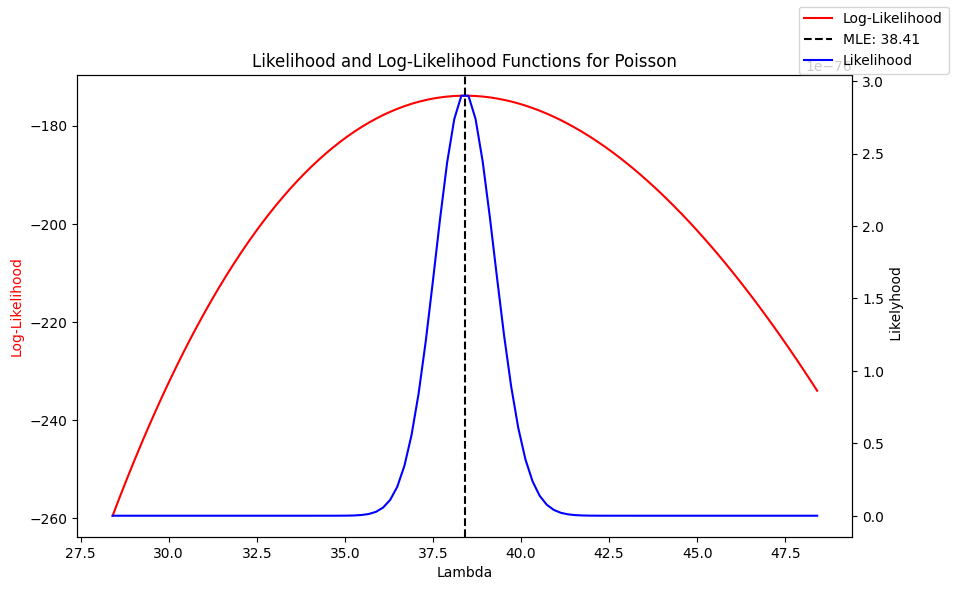

MLE Lambda: 38.41


In [5]:
# Calculate the MLE (just the sample mean)
lambda_mle = emails_df['y'].mean()

# Range for plotting around the MLE
lambda_values = np.linspace(lambda_mle - 10, lambda_mle + 10, 100)

# Calculate Log-Likelihood for each lambda value


# ~from math import factorial~     # apparently Scipy's gammaln is a better way # 
from scipy.special import gammaln
factorial_term = gammaln(emails_df['y'] + 1).sum()
n = len(emails_df)
sum_y = emails_df['y'].sum()

# Main calc
log_likelihoods = -n * lambda_values + np.log(lambda_values) * sum_y - factorial_term

# Likelihood is just e^log_likelihood
likelihoods = np.exp(log_likelihoods)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Lambda')
ax1.set_ylabel('Log-Likelihood', color='red')
ax1.plot(lambda_values, log_likelihoods, color='red', label='Log-Likelihood')
ax1.tick_params(axis='y')
ax1.axvline(lambda_mle, color='black', linestyle='--', label=f'MLE: {lambda_mle:.2f}')

ax2 = ax1.twinx()  # Second axis
ax2.set_ylabel(' Likelyhood')
ax2.plot(lambda_values, likelihoods, color='blue', label='Likelihood')
ax2.tick_params(axis='y')

plt.title('Likelihood and Log-Likelihood Functions for Poisson')
fig.legend()
plt.show()

print(f"MLE Lambda: {lambda_mle:.2f}")

### Nelder-Mead Algo

Worth nothing that since we want to max the log likelihood, this is equivalent to **minimizing** the negative log-likelihood.


Optimization Result:
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -5492.471209774306
             x: [ 3.841e+01]
           nit: 20
          nfev: 40
 final_simplex: (array([[ 3.841e+01],
                       [ 3.841e+01]]), array([-5.492e+03, -5.492e+03]))

MLE from optimization: 38.41
MLE from sample mean:  38.41


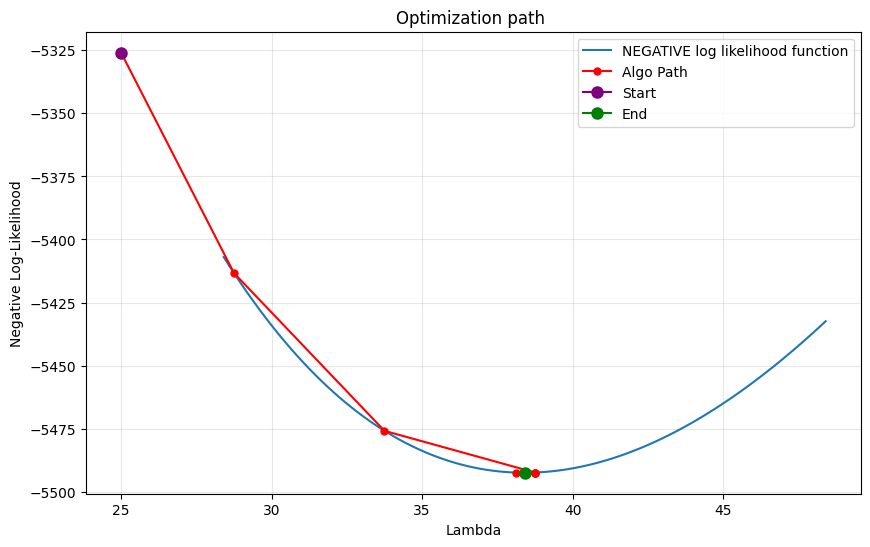

In [6]:



# the negative log likelihood fucntion:
def neg_log_lik(lam, y_data):

    n = len(y_data)
    sum_y = np.sum(y_data)               # I will leave out the factorial term since it won't make any difference

    return n * lam - np.log(lam) * sum_y

# The path to then plot, and callback function
path = []
def callback(x):
    path.append(x[0])

# The intial guess (and putting it inside the path list)
x0 = [25]
path.append(x0[0]) 

# Running the algo
result = minimize(
    neg_log_lik,
    x0,
    args=(emails_df['y'],),  # This was specially confusing, the passing of the tuple
    method='Nelder-Mead',
    callback=callback
)

print("Optimization Result:")
print(result)
print(f"\nMLE from optimization: {result.x[0]:.2f}")
print(f"MLE from sample mean:  {lambda_mle:.2f}")

# Plotting the path and previous MLE lambda
plt.figure(figsize=(10, 6))

# transforming the previous curve we used in the previous point into negative values
neg_log_likelihoods = [neg_log_lik(lamb, emails_df['y']) for lamb in lambda_values]

# creating a list with the neg log likelihood values for the points inside the path list
path_y = [neg_log_lik(points, emails_df['y']) for points in path]

plt.plot(lambda_values, neg_log_likelihoods, label='NEGATIVE log likelihood function')
plt.plot(path, path_y, 'o-', color='red', label='Algo Path', markersize=5)
plt.plot(path[0], path_y[0], marker = 'o', color = 'purple', label='Start', markersize=8)
plt.plot(path[-1], path_y[-1], marker = 'o', color = 'green', label='End', markersize=8)

plt.title('Optimization path ')
plt.xlabel('Lambda')
plt.ylabel('Negative Log-Likelihood')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Non-linear Modeling

The difference is evident just by looking at the plot, and if we look at diagnostics we can see the $ R^2: 0.99 $. It fits the data perfectly.

Best cubic parameters (a, b, c, d):
[ 0.50332543  1.93128621 -0.0874114   4.68727759]
Diagnostics for Cubic Model (curve_fit):

MSE: 7.08
R^2: 0.99


OLS Model:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     306.2
Date:                Thu, 12 Feb 2026   Prob (F-statistic):           4.66e-42
Time:                        04:14:27   Log-Likelihood:                -860.20
No. Observations:                 200   AIC:                             1724.
Df Residuals:                     198   BIC:                             1731.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      

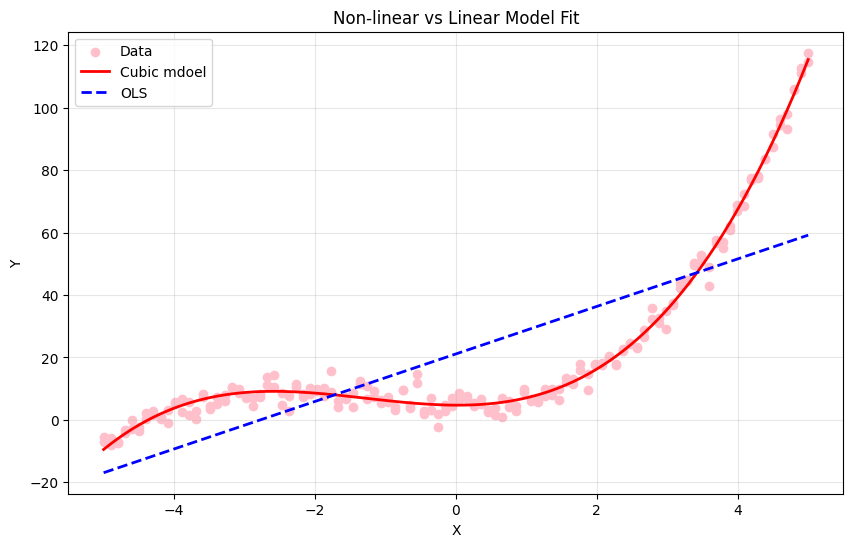

In [7]:

# display(curve_df.head(3))

# After spotting no columns in the csv file, use header=none
df = pd.read_csv('Q2_curve.csv', header=None)

# display(df.head(3)) # better

# separate data
x_data = df.iloc[:, 0].values 
y_data = df.iloc[:, 1].values

# Define custom model, after some tries i found it was a cubic model
def cubic_model(x, a, b, c, d):
    return a* x**3 + b* x**2 + c* x + d

# Curve_fit, using _ for the covariances (pcov) since I wont use them
popt, _ = curve_fit(cubic_model, x_data, y_data)
y_pred_curve = cubic_model(x_data, *popt) # This stores the predicted values


# Standard OLS fitting
X_ols = sm.add_constant(x_data)
model_ols = sm.OLS(y_data, X_ols).fit()
y_pred_ols = model_ols.predict(X_ols)

# Diagnostics for Cubic Model
# MSE
residuals_cubic = y_data - y_pred_curve
mse_cubic = np.mean(residuals_cubic**2)
# R2
ss_res_cubic = np.sum(residuals_cubic**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r2_cubic = 1 - (ss_res_cubic / ss_tot)



# Results
print("Best cubic parameters (a, b, c, d):")
print(popt)

print("Diagnostics for Cubic Model (curve_fit):")
print(f"\nMSE: {mse_cubic:.2f}")
print(f"R^2: {r2_cubic:.2f}")

print("\n\nOLS Model:")
print(model_ols.summary())


# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, label='Data', color='pink', )

# Since x is not sorted, matplotlib drew zigzags. Code to correct this:
sort_idx = np.argsort(x_data)
x_sorted = x_data[sort_idx] # "Fancy indexing" with numpy arrays
final_model = cubic_model(x_sorted, *popt)  # Store the model cleanly

plt.plot(x_sorted, final_model, color='red', label='Cubic mdoel', linewidth=2)
plt.plot(x_sorted, y_pred_ols[sort_idx], color='blue', linestyle='--', label='OLS', linewidth=2)
             # "Fancy indexing" again here


plt.title('Non-linear vs Linear Model Fit')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Question 3: Analysis of the 'house efficiency' dataset


### a) EDA

(I skip basics since it's all described in the assignment instructions pdf)

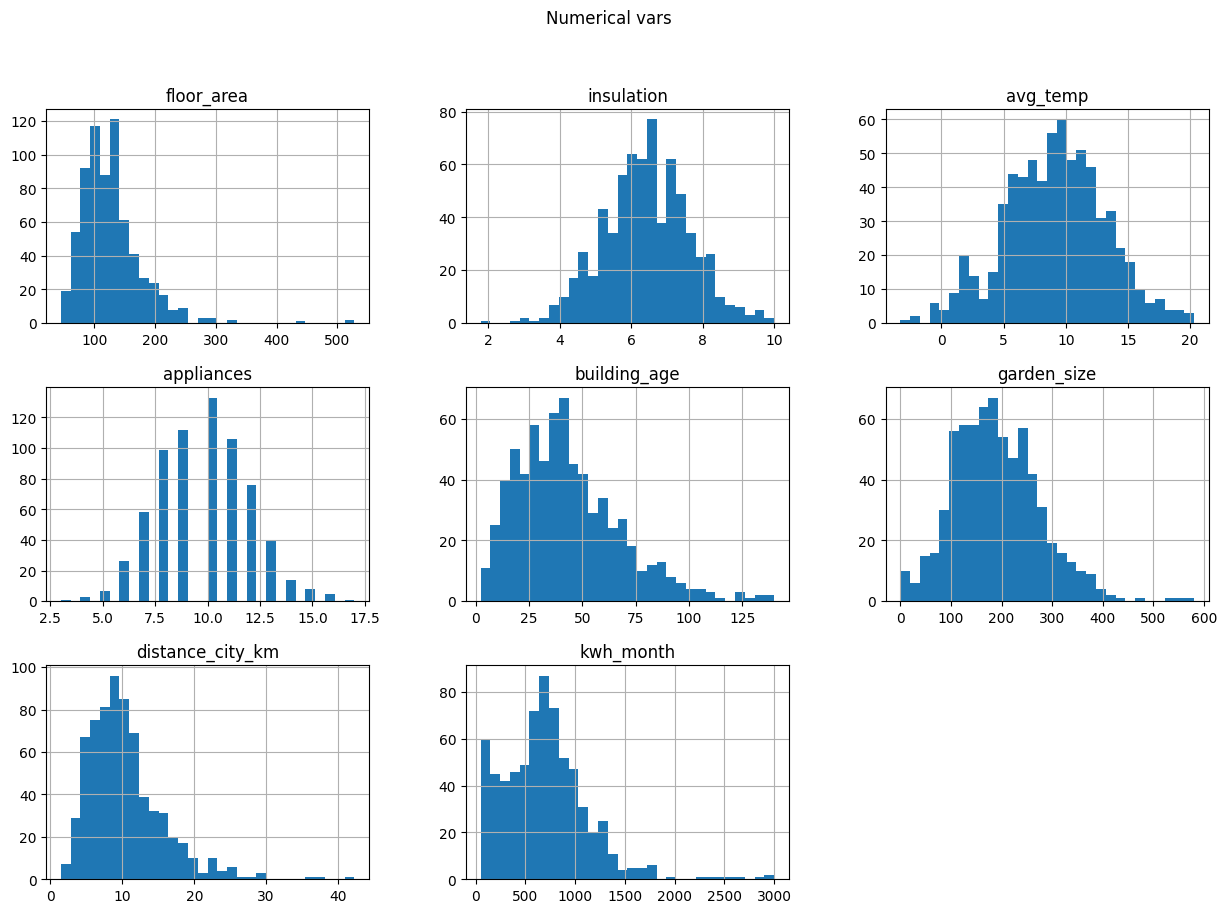

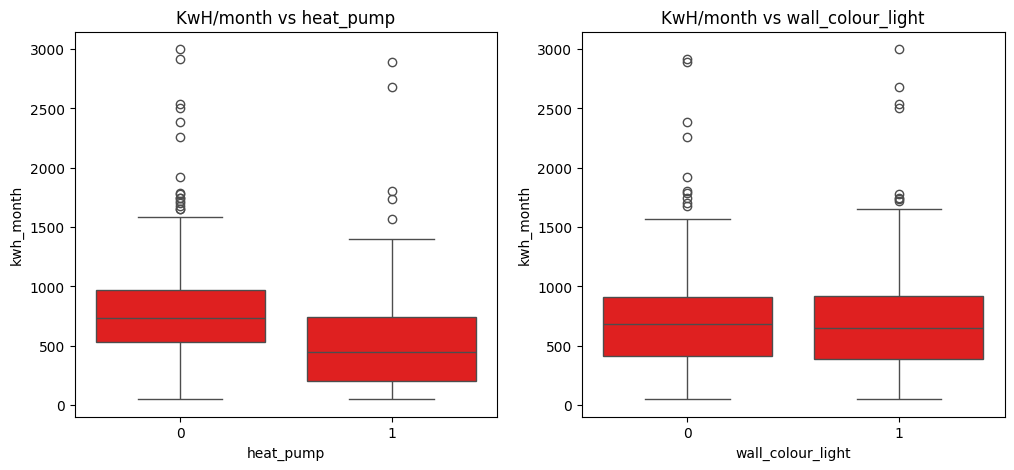

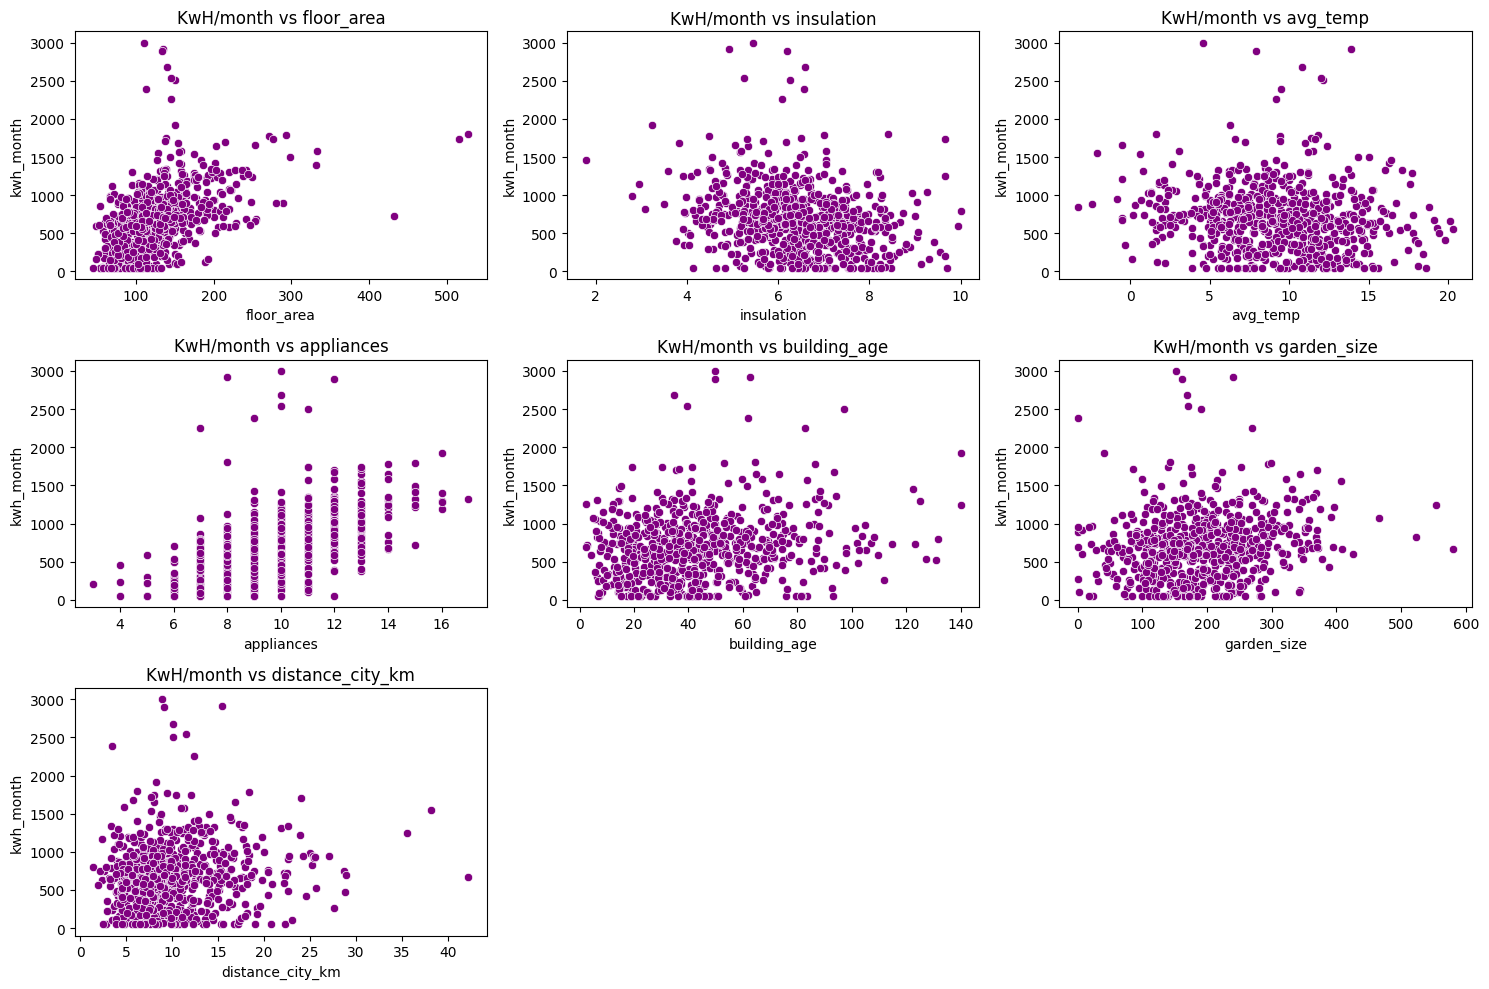

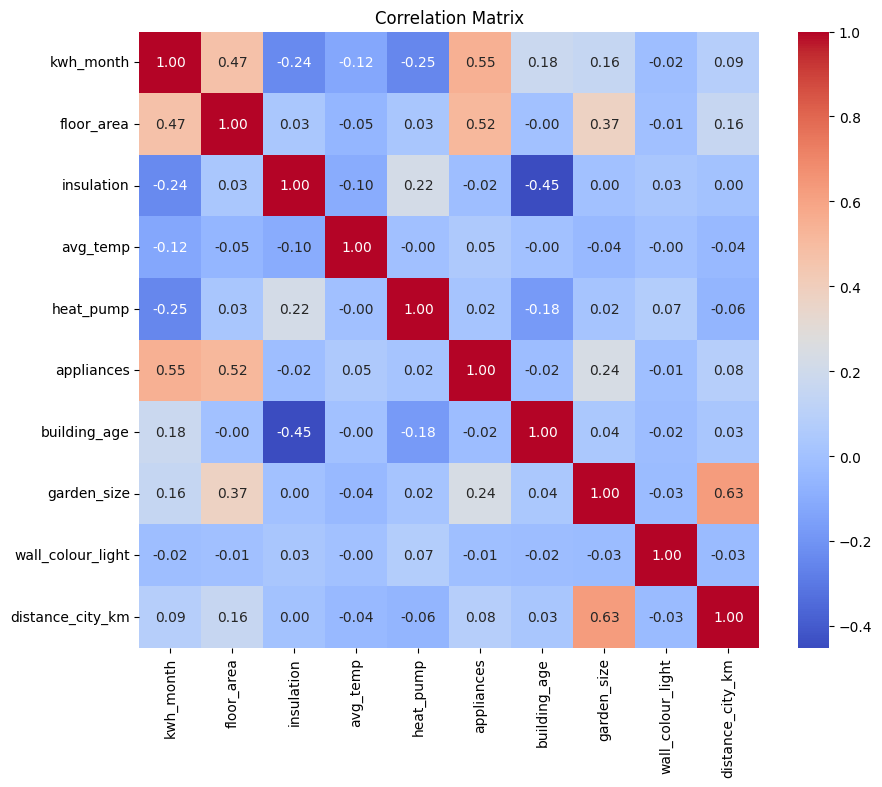

In [8]:
# house_df.info()

numerical_cols = ['floor_area', 'insulation', 'avg_temp', 'appliances', 'building_age', 'garden_size', 'distance_city_km']
categorical_cols = ['heat_pump', 'wall_colour_light']
target = 'kwh_month'

# Histograms
house_df[numerical_cols + [target]].hist(bins=30, figsize=(15, 10))
plt.suptitle('Numerical vars')
plt.show()

# Boxplots for categoricals
plt.figure(figsize=(12, 5))

for i, col in enumerate(categorical_cols):
    plt.subplot(1, 2, i+1)
    sns.boxplot(x=col, y=target, data=house_df, color = 'red')
    plt.title(f'KwH/month vs {col}')

plt.show()

# Scatter plots numericals vs KwH (Instead of pairplot because the latter is huge)

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=col, y=target, data=house_df, color = 'purple')
    plt.title(f'KwH/month vs {col}')

plt.tight_layout()
plt.show()

# Correlation Matrix

plt.figure(figsize=(10, 8))
corr_matrix = house_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### b) Model Fitting

Used train test split with backwards elimination. I selected of backward elimination since from the correlation matrix and the scatter plots we can see just how little most variables explain of the target var.

We can see a huge increase in Adj R2 towards the end when all features with pval > 0.05 are eliminated

In [9]:


#Train-Test Split

X = house_df.drop(columns=['kwh_month'])
y = house_df['kwh_month']


X = sm.add_constant(X)     # constant
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Bbackward elimination
# We will iteratively remove the feature with the highest p-value if it is > 0.05

# Function to perform backward elimination 
# (Credit to https://nerchukoacademy.graphy.com/blog/backward-elimination-building-simpler-smarter-models)

def backward_elimination(x, y, significance_level=0.05):
  
    current_x = x.copy()
    num_vars = current_x.shape[1]  # Counts columns (num of regressors)
    
    for i in range(0, num_vars):  # Try maximum num_vars times

        model = sm.OLS(y, current_x).fit()  # Fits the model
        max_p_value = max(model.pvalues)
        current_adj_r2 = model.rsquared_adj

        if max_p_value > significance_level:       # Deletes the feature if p> 0.05
            exclude_feature = model.pvalues.idxmax()
            current_x = current_x.drop(columns=[exclude_feature])
            print(f"Removed feature: {exclude_feature} (p-value: {max_p_value:.4f}), adj r^2: {current_adj_r2:.3f}")  
        else:
            break
    return model, current_x


# Executing the elimination
print("Start of backward elimination")
final_model, X_train_final = backward_elimination(X_train, y_train)

print("\nFinal Model Summary:")
print(final_model.summary())

# Coefficients
print("\nInterpretation of Significant Coefficients:")
for feature, coef in final_model.params.items():
    if feature == 'const':
        continue
    print(f"- {feature}: {coef:.2f} (Change in kwh_month per unit increase)")

Start of backward elimination
Removed feature: wall_colour_light (p-value: 0.8217), adj r^2: 0.463
Removed feature: distance_city_km (p-value: 0.3793), adj r^2: 0.464
Removed feature: garden_size (p-value: 0.1620), adj r^2: 0.464
Removed feature: const (p-value: 0.1966), adj r^2: 0.463

Final Model Summary:
                                 OLS Regression Results                                
Dep. Variable:              kwh_month   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.856
Method:                 Least Squares   F-statistic:                              545.5
Date:                Thu, 12 Feb 2026   Prob (F-statistic):                   1.13e-226
Time:                        04:14:32   Log-Likelihood:                         -3947.4
No. Observations:                 551   AIC:                                      7907.
Df Residuals:                     545   BIC:                               

### c) Diagnostics

We evaluate the final model by checking the assumptions of linear regression: linearity, homoscedasticity, and normality of residuals. We also identify potential influential observations.

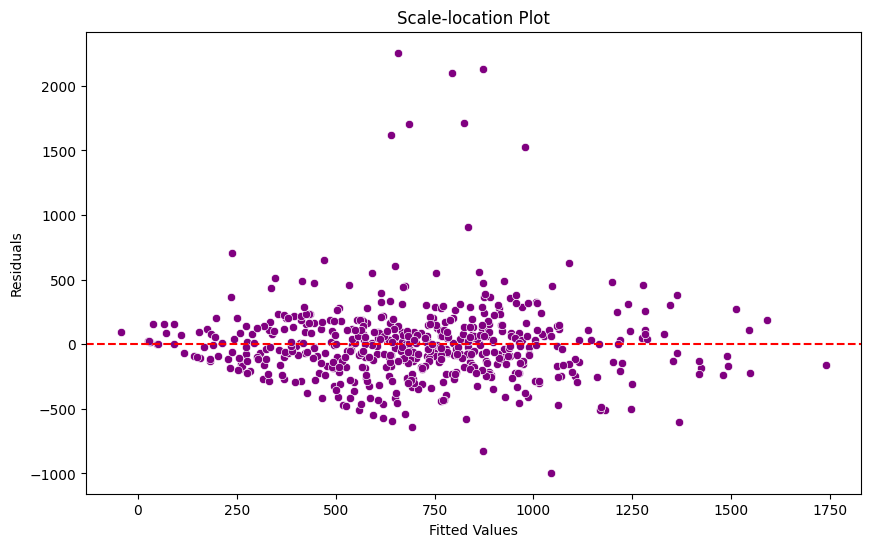

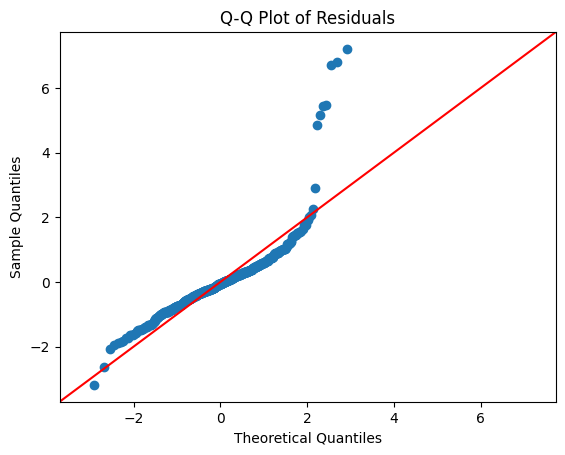

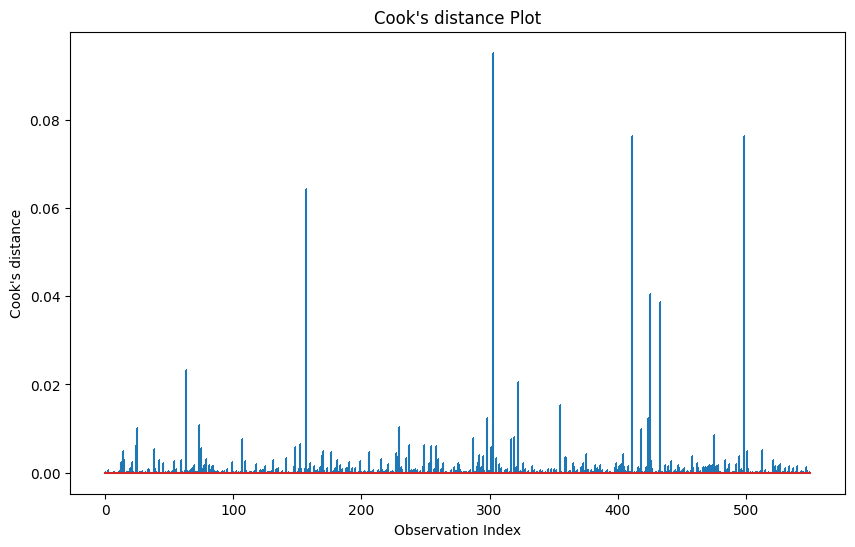

Threshold for Cook's Distance (4/n): 0.0073
Number of influential observations: 20
Indices of influential observations: [ 25  63  73 107 157 229 287 298 303 317 319 322 355 411 418 424 425 433
 475 499]
Original Indices: [365, 398, 162, 343, 41, 338, 340, 349, 532, 511, 121, 636, 114, 341, 585, 608, 39, 290, 545, 200]


In [10]:
# Scale location
residuals = final_model.resid
fitted_values = final_model.fittedvalues

plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals,  color = 'purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scale-location Plot')
plt.show()

# QQ plot
fig = sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()


# Cook's distance
influence = final_model.get_influence()
(c, p) = influence.cooks_distance

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.xlabel('Observation Index')
plt.ylabel("Cook's distance")
plt.title("Cook's distance Plot")
plt.show()

#rule of thumb: 4/n
n = len(X_train_final)
threshold = 4 / n
influential_points = np.where(c > threshold)[0]

print(f"Threshold for Cook's Distance (4/n): {threshold:.4f}")


# To show how to identify these points
print(f"Number of influential observations: {len(influential_points)}")
print("Indices of influential observations:", influential_points)
# or...
influential_indices = X_train_final.index[influential_points]
print("Original Indices:", influential_indices.tolist())

**Detailed Discussion of Diagnostics:**

1.  **Linearity & Homoscedasticity (Residuals vs Fitted):**
    - Almost a random pattern, obviously the outliers are there but with some management it looks promising

2.  **Normality of Residuals (Q-Q Plot):**
    - Here we see the real impact of the outliers. 
    - We could log transform the KWh/month or just get rid of the observations  
    -  or add an income and/or disposable income, + 'environmental conscience' feature to maybe tackle some more extreme values

3.  **Influential Observations (Cook's Distance):**
    - The influential points seem to be right skewed. Therefore we could add the above mentioned features to tackle those, or we could exclude them based on some 'domain specific' reason, but not just because they 'distort' the model.
    - These outliers make us overestimate kwh/month consumption.
    - As presented in the code, we can easily identify them. We can present both models, with and without these points, and try to tackle the variation they add.

4. **OLS assumptions:** Main issue is non-normality of residuals and outliers, log transforming the target variable and managing outliers should significantly improve things.

### d) Collinearity

We can see that there are various features with VIF> 5, this might be expected given how poor the data was when we saw the correlation matrix. 

The effect is that Standard errors get inflated, hypothesis testing is bad/invalid, and we would struggle to define which features are (not) significant. 

Backwards elimnation like we've done is not likely to be accurate, for a better model, using a hybrid approach between eliminating high VIF features and adding/substracting features would likely yield a better result


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_final.values, i) for i in range(X_train_final.shape[1])]

print(vif_data)

        feature        VIF
0    floor_area  12.068692
1    insulation  14.283637
2      avg_temp   5.561401
3     heat_pump   1.469350
4    appliances  27.502294
5  building_age   4.045844


### 3.5 Prediction and Evaluation


We can see that appliances, insulation, and floor area quite impactful. However, 'raw' numbers don't really tell much since we are comparing an additional appliance to an additional square meter of flooring.... **Apples to oranges**

If we log the data we can talk in % increases which would make more sense!

In [12]:
# Enter all data
new_household_data = {
    'floor_area': 160,
    'insulation': 6,
    'avg_temp': 8,
    'heat_pump': 1,
    'appliances': 12,
    'building_age': 35,
    'garden_size': 180,
    'wall_colour_light': 1,
    'distance_city_km': 7
}

new_household_df = pd.DataFrame([new_household_data])

new_household_df = sm.add_constant(new_household_df, has_constant='add')

# We have to drop the features that we removed during backwards elimination
features_needed = X_train_final.columns.tolist()
new_household_prepared = new_household_df[features_needed]

# Predict
prediction = final_model.predict(new_household_prepared)
predicted_value = prediction[0]
print(f"predicted monthly  consumption: {predicted_value:.2f} kWh")

# Analyze feature contributions
print("\nFeature contributions to the prediction:")

for feature in features_needed:
    coef = final_model.params[feature]
    values = new_household_prepared.iloc[0][feature]
    contribution = coef * values
    print(f"     {feature}: {values} * {coef:.2f} = {contribution:.2f}  kwh/month")

predicted monthly  consumption: 829.31 kWh

Feature contributions to the prediction:
     floor_area: 160 * 2.01 = 321.86  kwh/month
     insulation: 6 * -46.72 = -280.33  kwh/month
     avg_temp: 8 * -14.58 = -116.63  kwh/month
     heat_pump: 1 * -219.46 = -219.46  kwh/month
     appliances: 12 * 88.52 = 1062.23  kwh/month
     building_age: 35 * 1.76 = 61.65  kwh/month


## Question 4: Logistic Regression to detect phishing emails

We develop a logistic regression model to classify emails as spam/phishing or non-spam using the `spam_phishing.csv` dataset.

In [13]:


# Separating observations
train_df = spam_df.iloc[:400].copy()
test_50_df = spam_df.iloc[400:].copy()

print(f"Original dataset size: {len(spam_df)}")
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_50_df)}")


Original dataset size: 450
Training set size: 400
Test set size: 50


### EDA

Separating the plots by the Is_spam field is key here. We can see from the start:

- Not much explanatory power in attachment size, yet emails with a smaller relative size might be spam.
- avg higher special char in spam emails, but still similar spread to non spam
- extremely low special characters might indicate not-spam
- fishy words strong indicator of spam

Proportions of is_spam in Training Set:
is_spam
1    0.5
0    0.5
Name: proportion, dtype: float64


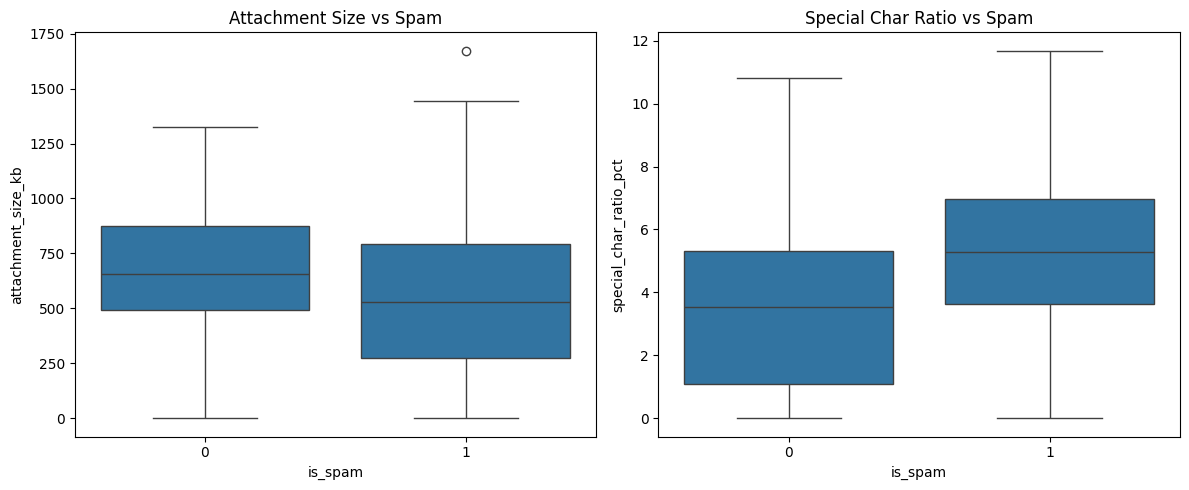

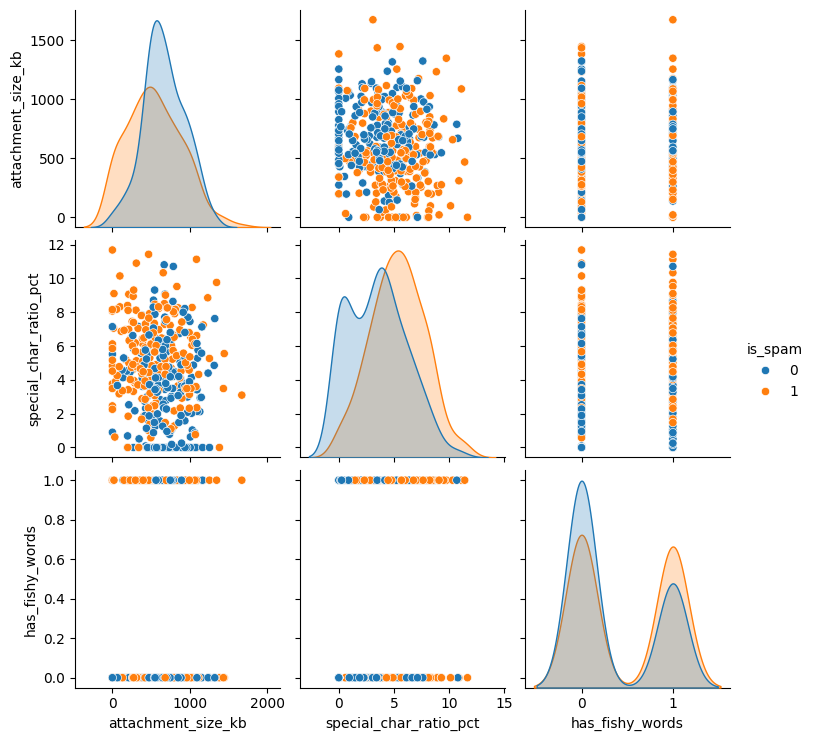

In [14]:
# Proportions of Is-spam
print("Proportions of is_spam in Training Set:")
print(train_df['is_spam'].value_counts(normalize=True))  # half is spam, half isnt

# PLOTS
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='is_spam', y='attachment_size_kb', data=train_df)
plt.title('Attachment Size vs Spam')



plt.subplot(1, 2, 2)
sns.boxplot(x='is_spam', y='special_char_ratio_pct', data=train_df)
plt.title('Special Char Ratio vs Spam')
plt.tight_layout()
plt.show()
sns.pairplot(train_df, hue='is_spam', vars=['attachment_size_kb', 'special_char_ratio_pct','has_fishy_words'])
plt.show()

### Fit

Interpretation of model outputs and Odds ratio:

- The Odds Ratio represents the  change in the odds of the outcome for a one-unit increase in the predictor variable, holding all other variables constant.

**In the case of:**

- Attachment size: it indicates how the odds of being spam change for every 1 KB increase in attachment size.

- Special characters:  it indicates the factor by which the odds of being spam increase for every 1% increase in special character content. (consistent with our EDA observations)

- Fishy words (binary): the ratio compares the presence of the feature vs. its absence, i.e. it how many times higher/lower the odds of being spam are for an email containing suspicious words compared to one that doesn't




In [15]:
# separating data & constant
X_train = train_df[['attachment_size_kb', 'special_char_ratio_pct', 'has_fishy_words']]
y_train = train_df['is_spam']
X_train_const = sm.add_constant(X_train) 

# Fit
logit_model = sm.Logit(y_train, X_train_const).fit()
print(logit_model.summary())

# Odds ratio
print("\nOdds Ratios:")
print(np.exp(logit_model.params))

Optimization terminated successfully.
         Current function value: 0.610371
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                is_spam   No. Observations:                  400
Model:                          Logit   Df Residuals:                      396
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Feb 2026   Pseudo R-squ.:                  0.1194
Time:                        04:14:42   Log-Likelihood:                -244.15
converged:                       True   LL-Null:                       -277.26
Covariance Type:            nonrobust   LLR p-value:                 2.749e-14
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.6717      0.314     -2.138      0.033      -1.287      

### 4.3 Prediction

A higher threshold (0.7):
-  makes the model more conservative in classifying an email as spam

-  but increases false negatives (i.e. spam emails that went undetected)



--- Threshold: 0.5 ---
Confusion Matrix:
[[19 6]
 [9 16]]
TPR (Recall): 0.6400, FPR: 0.2400

--- Threshold: 0.7 ---
Confusion Matrix:
[[23 2]
 [17 8]]
TPR (Recall): 0.3200, FPR: 0.0800


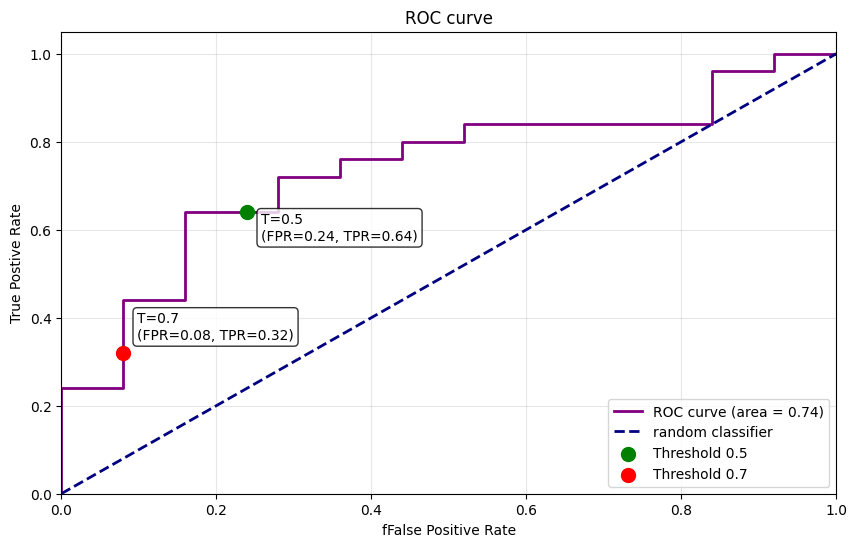

In [16]:
from sklearn.metrics import roc_curve, auc, confusion_matrix

# data
X_test = test_50_df[['attachment_size_kb', 'special_char_ratio_pct', 'has_fishy_words']]
y_test = test_50_df['is_spam']
X_test_const = sm.add_constant(X_test)

# Predicts
y_pred_prob = logit_model.predict(X_test_const)

# ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='purple', linewidth=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label= 'random classifier')

# Plot specific thresholds
target_thresholds = [0.5, 0.7]
colors = ['green', 'red']

for i, t in enumerate(target_thresholds):
   
   # Calculating points in plot, + confusion matrix
    y_pred_t = (y_pred_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    tpr_t = tp / (tp + fn)
    fpr_t = fp / (fp + tn)
    
    plt.scatter(fpr_t, tpr_t, color=colors[i], s=100, zorder=5, label=f'Threshold {t}')
    plt.annotate(f'T={t}\n(FPR={fpr_t:.2f}, TPR={tpr_t:.2f})', 
                 (fpr_t, tpr_t), 
                 textcoords="offset points", 
                 xytext=(10,-20 if i==0 else 10), 
                 ha='left', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))
    
   

   # prints
    print(f"\n--- Threshold: {t} ---")
    print("Confusion Matrix:")
    print(f"[[{tn} {fp}]\n [{fn} {tp}]]")
    print(f"TPR (Recall): {tpr_t:.4f}, FPR: {fpr_t:.4f}")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('fFalse Positive Rate')
plt.ylabel('True Postive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### Part 2: Questions

**Question 1: Email Comparison**

Assuming that we do not know the size of the very large attachment, and just take it as X and X+120 for email B:, and that email B has 4x the special characters as email A, then we just calculate the difference in log odds and see if it's positive or negative to see which is more likely to be spam.

**Result: Mail B is more likely to be spam**




In [17]:
# Coefficients
params = logit_model.params
beta_attach = params['attachment_size_kb']
beta_special = params['special_char_ratio_pct']
beta_fishy = params['has_fishy_words']


# log odds email A = beta_attach* X + beta_special*1 + beta_fishy*1
# Log odds email B = beta_attach*(X+120) + beta_special*4 + beta_fishy*0


# differnece  (B-A )= 120*beta_attach + 3*beta_special- beta_fishy * 1

diff_log_odds = 120 * beta_attach + 3* beta_special - beta_fishy

print(f"Coefficients: Attach={beta_attach:.4f}, Special={beta_special:.4f}, Fishy={beta_fishy:.4f}")
print(f"Log-Odds Difference (B-A)): {diff_log_odds:.4f}")

if diff_log_odds > 0:
    print("mail B has a higher probability of being sapm.")
else:
    print("Email A has a higher probability of being spam.")

Coefficients: Attach=-0.0012, Special=0.2682, Fishy=0.5129
Log-Odds Difference (B-A)): 0.1501
mail B has a higher probability of being sapm.


**Question 2: Sender Type Variable**


-  **Inclusion:** We would treat this as a categorical variable and use one hot encoding (dummy variables). One level would be the baseline. and then we would have 2 additionaly vars that reflect when the sender deviate from the baseline

If we assume known is the baseline type, then:  

-   $\beta_{unknown}$: The change in log-odds of being spam when the sender is unknown compared to known
 -   $\beta_{trusted}$: The change in log-odds of being spam when the sender is a trusted entity compared to known

- Interpretation:
    -   $e^{\beta_{unknown}}$: The multiplicative factor by which the odds of spam increase if the sender is unknown compared to a known contact.
    -   $e^{\beta_{trusted}}$ The multiplicative factor by which the odds of spam increase if the sender is trusted compared to a known contact.  

 - Pre judgement:
    -   Unknown senders will probably show a positive coefficient

    -   Trusted entities (if verified) should have a 0 (no effect) or negative coefficient (vs known), but if it is unverified (i.e. only claiming to be a trusted entity) then it would be massively positive.